# Relativistic Wasserstein Deep Convolutional Q-GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [ ]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [ ]:
!mkdir data

## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [ ]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [ ]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

In [ ]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [ ]:
def scale(x, feature_range=(-1, 1)): # tanh
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range (-1, 1)
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [ ]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [ ]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512)
        h1 = tf.reshape(x, (-1, 4, 4, 512))
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now
        
        h2 = tf.layers.conv2d_transpose(nl1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        h3 = tf.layers.conv2d_transpose(nl2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(nl3, output_dim, 5, strides=2, padding='same')
        out = tf.tanh(logits)
        # 32x32x3 now
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [ ]:
def discriminator(x, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(nl1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(nl2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        h4_flat = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(h4_flat, 1)
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [ ]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    input_gen = generator(input_z, output_dim, alpha=alpha)
    Q = discriminator(input_real, alpha=alpha)
    q = discriminator(input_gen, alpha=alpha, reuse=True)
    d_loss = tf.reduce_mean(q-Q) 
    g_loss = tf.reduce_mean(Q-q)
    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [ ]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [ ]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        self.input_real, self.input_z = model_inputs(real_dim=real_size, z_dim=z_size)
        
        self.d_loss, self.g_loss = model_loss(input_real=self.input_real, input_z=self.input_z, 
                                              output_dim=real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(d_loss=self.d_loss, g_loss=self.g_loss, learning_rate=learning_rate, 
                                           beta1=beta1)

Here is a function for displaying generated images.

In [ ]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [ ]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                if len(x) != batch_size:
                    print(batch_z.shape, x.shape)
                    
                else:
                    # Run optimizers
                    dloss, _ = sess.run([net.d_loss, net.d_opt], feed_dict={net.input_real: x, 
                                                                            net.input_z: batch_z})
                    gloss, _ = sess.run([net.g_loss, net.g_opt], feed_dict={net.input_real: x, 
                                                                            net.input_z: batch_z})

                    steps += 1
                    if steps % print_every == 0:
                        print("Epoch {}/{}...".format(e+1, epochs),
                              "Dloss: {:.4f}".format(dloss),
                              "Gloss: {:.4f}".format(gloss))
                        # Save losses to view after training
                        losses.append((dloss, gloss))

                    if steps % show_every == 0:
                        gen_samples = sess.run(
                                       generator(net.input_z, 3, reuse=True, training=False),
                                       feed_dict={net.input_z: sample_z})
                        samples.append(gen_samples)
                        _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                        plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')
        with open('samples.pkl', 'wb') as f:
            pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 100
alpha = 0.2
beta1 = 0.5

tf.reset_default_graph()

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

dataset = Dataset(trainset, testset)

Epoch 1/100... Dloss: -2.6138 Gloss: 11.1364
Epoch 1/100... Dloss: -17.2284 Gloss: 29.2590
Epoch 1/100... Dloss: -21.6254 Gloss: 34.4353
Epoch 1/100... Dloss: -50.9533 Gloss: 61.7411
Epoch 1/100... Dloss: -56.1674 Gloss: 67.7524
Epoch 1/100... Dloss: -67.2707 Gloss: 81.4464
Epoch 1/100... Dloss: -42.4828 Gloss: 65.4575
Epoch 1/100... Dloss: -4.8277 Gloss: 15.4793
Epoch 1/100... Dloss: -25.6068 Gloss: 35.2315
Epoch 1/100... Dloss: -43.7655 Gloss: 57.6383


/home/arasdar/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1324: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


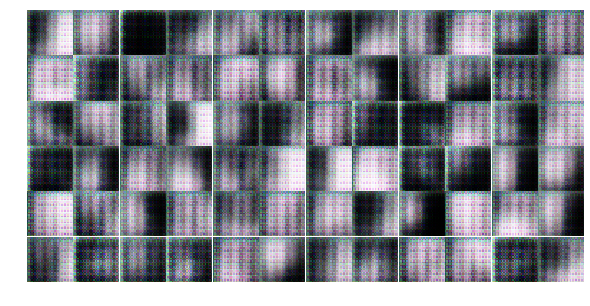

Epoch 1/100... Dloss: -64.1332 Gloss: 78.1616
Epoch 1/100... Dloss: -81.2038 Gloss: 89.0413
Epoch 1/100... Dloss: -94.7135 Gloss: 106.9680
Epoch 1/100... Dloss: -80.2148 Gloss: 104.0693
Epoch 1/100... Dloss: -91.7032 Gloss: 107.9272
Epoch 1/100... Dloss: -100.6118 Gloss: 115.8037
Epoch 1/100... Dloss: -116.7050 Gloss: 129.4257
Epoch 1/100... Dloss: -113.3441 Gloss: 130.5654
Epoch 1/100... Dloss: -74.6329 Gloss: 111.4447
Epoch 1/100... Dloss: -102.6773 Gloss: 111.7763


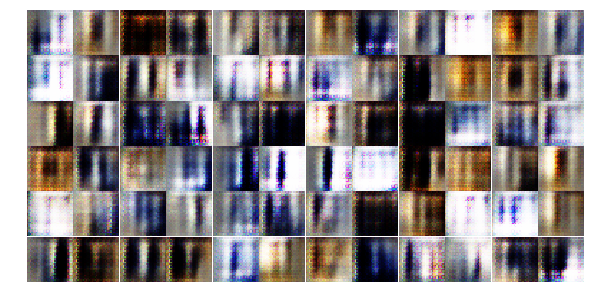

Epoch 1/100... Dloss: -77.9299 Gloss: 113.8565
Epoch 1/100... Dloss: -113.8640 Gloss: 154.5403
Epoch 1/100... Dloss: -97.0700 Gloss: 132.2506
Epoch 1/100... Dloss: -145.2008 Gloss: 160.2587
Epoch 1/100... Dloss: -159.5701 Gloss: 161.7794
Epoch 1/100... Dloss: -115.3440 Gloss: 138.5739
Epoch 1/100... Dloss: -265.7635 Gloss: 270.8943
Epoch 1/100... Dloss: -202.8586 Gloss: 232.6231
Epoch 1/100... Dloss: -222.5610 Gloss: 200.0535
Epoch 1/100... Dloss: -65.3781 Gloss: 119.6869


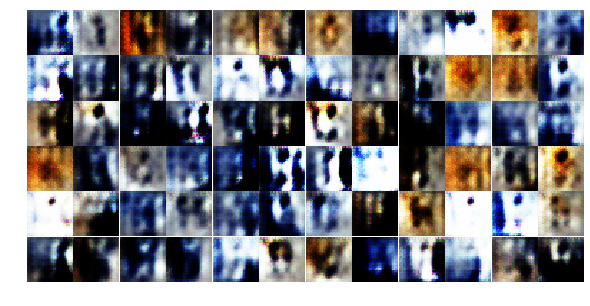

Epoch 1/100... Dloss: -154.0901 Gloss: 234.5949
Epoch 1/100... Dloss: -157.7212 Gloss: 220.3537
Epoch 1/100... Dloss: -154.6504 Gloss: 215.6640
Epoch 1/100... Dloss: -8.2515 Gloss: 8.5368
Epoch 1/100... Dloss: -45.8290 Gloss: 81.2613
Epoch 1/100... Dloss: -176.7357 Gloss: 58.5661
Epoch 1/100... Dloss: -341.3135 Gloss: 351.4552
Epoch 1/100... Dloss: -324.1749 Gloss: 338.6471
Epoch 1/100... Dloss: -293.8640 Gloss: 329.5593
Epoch 1/100... Dloss: -253.0015 Gloss: 336.4808


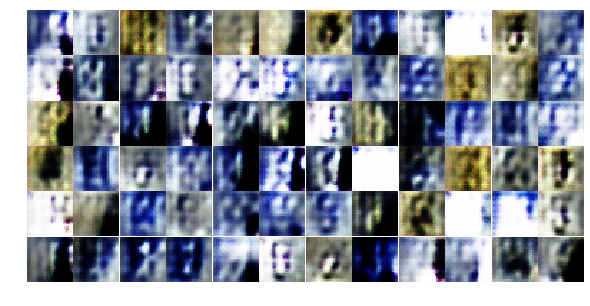

Epoch 1/100... Dloss: -415.9792 Gloss: 421.7513
Epoch 1/100... Dloss: -337.9656 Gloss: 209.5762
Epoch 1/100... Dloss: -455.1248 Gloss: 460.5242
Epoch 1/100... Dloss: -485.2631 Gloss: 488.4698
Epoch 1/100... Dloss: -513.2041 Gloss: 516.0707
Epoch 1/100... Dloss: -533.3598 Gloss: 536.5433
Epoch 1/100... Dloss: -550.8694 Gloss: 554.1693
Epoch 1/100... Dloss: -567.1723 Gloss: 570.9733
Epoch 1/100... Dloss: -563.3600 Gloss: 569.8046
Epoch 1/100... Dloss: -25.8489 Gloss: 74.0295


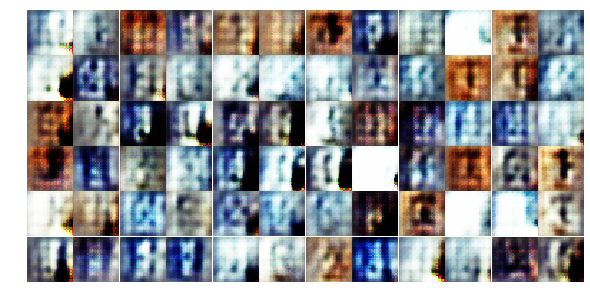

Epoch 1/100... Dloss: -53.4479 Gloss: 118.2252
Epoch 1/100... Dloss: -76.9056 Gloss: 138.2456
Epoch 1/100... Dloss: -153.9608 Gloss: 239.4790
Epoch 1/100... Dloss: -159.6248 Gloss: 201.6278
Epoch 1/100... Dloss: -190.0496 Gloss: 321.5340
Epoch 1/100... Dloss: -257.6209 Gloss: 340.2296
Epoch 1/100... Dloss: -288.8112 Gloss: 370.7328
(128, 100) (41, 32, 32, 3)
Epoch 2/100... Dloss: -525.0137 Gloss: 566.2120
Epoch 2/100... Dloss: -142.7998 Gloss: 206.2608
Epoch 2/100... Dloss: -36.9996 Gloss: 27.8277


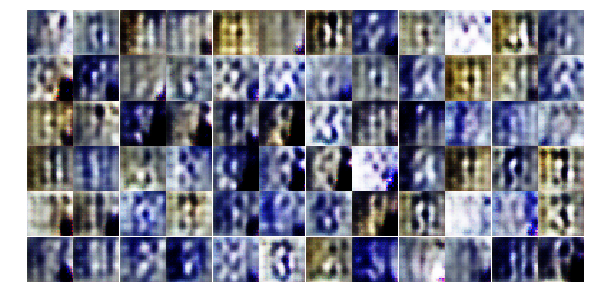

Epoch 2/100... Dloss: -233.9823 Gloss: 331.4095
Epoch 2/100... Dloss: -543.9752 Gloss: 583.6016
Epoch 2/100... Dloss: -206.6097 Gloss: 302.2681
Epoch 2/100... Dloss: -437.5462 Gloss: 491.4456
Epoch 2/100... Dloss: -135.3665 Gloss: 348.8832
Epoch 2/100... Dloss: -257.3036 Gloss: 321.7601
Epoch 2/100... Dloss: -264.7395 Gloss: 426.7826
Epoch 2/100... Dloss: -242.7130 Gloss: 158.5315
Epoch 2/100... Dloss: -30.8272 Gloss: 26.5133
Epoch 2/100... Dloss: -72.4239 Gloss: 269.9276


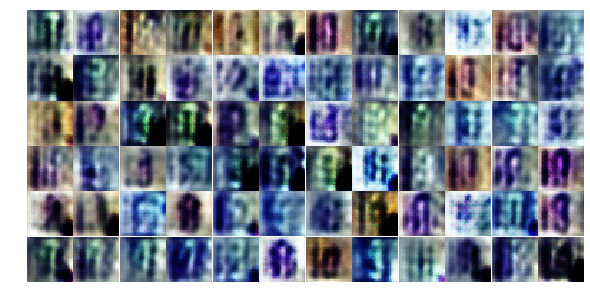

Epoch 2/100... Dloss: -146.0473 Gloss: 232.4616
Epoch 2/100... Dloss: -236.5987 Gloss: 372.0511
Epoch 2/100... Dloss: -184.8209 Gloss: 238.2517
Epoch 2/100... Dloss: -112.5005 Gloss: 251.3900
Epoch 2/100... Dloss: -115.2449 Gloss: 269.8617
Epoch 2/100... Dloss: -102.9480 Gloss: 211.7579
Epoch 2/100... Dloss: -397.5131 Gloss: 473.4297
Epoch 2/100... Dloss: -240.4642 Gloss: 326.2237
Epoch 2/100... Dloss: -379.8484 Gloss: 511.2927
Epoch 2/100... Dloss: -347.6471 Gloss: 443.0762


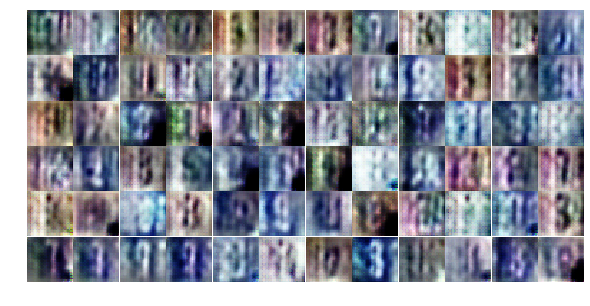

Epoch 2/100... Dloss: -633.7938 Gloss: 705.8431
Epoch 2/100... Dloss: -225.5600 Gloss: 293.3044
Epoch 2/100... Dloss: -234.2870 Gloss: 190.5107
Epoch 2/100... Dloss: -398.2834 Gloss: 367.4209
Epoch 2/100... Dloss: -119.1531 Gloss: 217.2755
Epoch 2/100... Dloss: -161.1691 Gloss: 324.2976
Epoch 2/100... Dloss: -368.0196 Gloss: 289.6693
Epoch 2/100... Dloss: -14.3938 Gloss: 38.3951
Epoch 2/100... Dloss: 22.0287 Gloss: -3.5449
Epoch 2/100... Dloss: -25.8014 Gloss: 40.5263


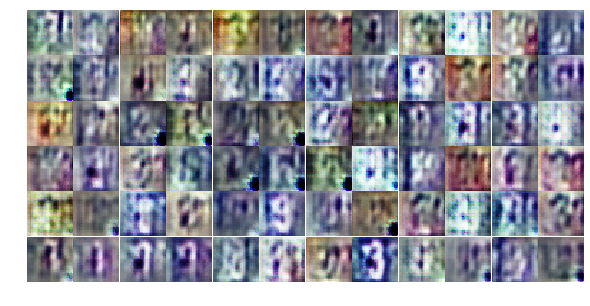

Epoch 2/100... Dloss: -9.2766 Gloss: 27.9656
Epoch 2/100... Dloss: -35.8674 Gloss: 59.7947
Epoch 2/100... Dloss: -56.6661 Gloss: 101.0019
Epoch 2/100... Dloss: -125.2561 Gloss: 199.3664
Epoch 2/100... Dloss: -151.1667 Gloss: 271.2321
Epoch 2/100... Dloss: -632.8661 Gloss: 697.0305
Epoch 2/100... Dloss: -35.8564 Gloss: 332.0486
Epoch 2/100... Dloss: -119.5504 Gloss: 313.8765
Epoch 2/100... Dloss: -52.5907 Gloss: 112.1804
Epoch 2/100... Dloss: -250.4836 Gloss: 412.0242


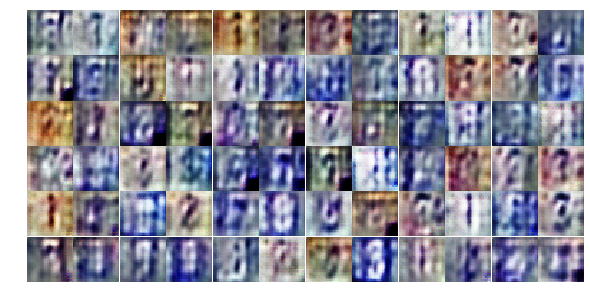

Epoch 2/100... Dloss: -662.3181 Gloss: 470.1754
Epoch 2/100... Dloss: -446.6260 Gloss: 535.0566
Epoch 2/100... Dloss: -305.8082 Gloss: 380.6332
Epoch 2/100... Dloss: -318.3177 Gloss: 214.6822
Epoch 2/100... Dloss: -455.9557 Gloss: 511.2343
Epoch 2/100... Dloss: -221.3216 Gloss: 367.1360
Epoch 2/100... Dloss: -222.5346 Gloss: 349.8135
Epoch 2/100... Dloss: -141.6337 Gloss: 341.9001
Epoch 2/100... Dloss: -51.6277 Gloss: 282.7173
Epoch 2/100... Dloss: -348.1687 Gloss: 504.1982


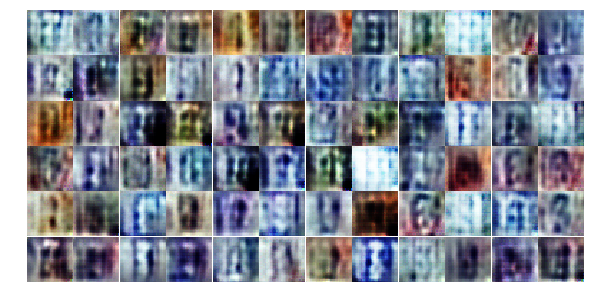

Epoch 2/100... Dloss: -74.0026 Gloss: 235.9529
Epoch 2/100... Dloss: 10.1583 Gloss: 70.4850
Epoch 2/100... Dloss: 38.7037 Gloss: -15.9880
Epoch 2/100... Dloss: 3.5147 Gloss: 23.3542
(128, 100) (41, 32, 32, 3)
Epoch 3/100... Dloss: 28.6855 Gloss: 15.9271
Epoch 3/100... Dloss: -118.0981 Gloss: 180.5782
Epoch 3/100... Dloss: -290.1850 Gloss: 390.3677
Epoch 3/100... Dloss: -70.4422 Gloss: 241.2869
Epoch 3/100... Dloss: -347.9291 Gloss: 503.6522
Epoch 3/100... Dloss: -95.1988 Gloss: 310.3226


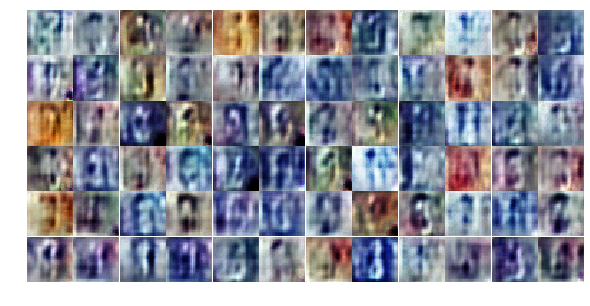

Epoch 3/100... Dloss: -175.7129 Gloss: 291.6565
Epoch 3/100... Dloss: -232.2726 Gloss: 476.6115
Epoch 3/100... Dloss: -429.1946 Gloss: 340.8933
Epoch 3/100... Dloss: -285.7652 Gloss: 311.7552
Epoch 3/100... Dloss: -342.6092 Gloss: 141.8595
Epoch 3/100... Dloss: -303.5432 Gloss: 386.4915
Epoch 3/100... Dloss: -318.1205 Gloss: 633.1210
Epoch 3/100... Dloss: 7.4390 Gloss: 429.0321
Epoch 3/100... Dloss: -290.9094 Gloss: 608.5469
Epoch 3/100... Dloss: -40.6200 Gloss: 224.7958


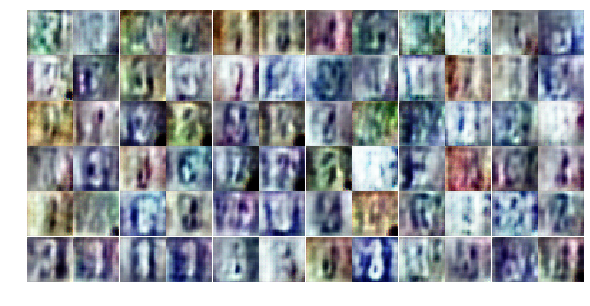

Epoch 3/100... Dloss: -89.7922 Gloss: 144.9395
Epoch 3/100... Dloss: -232.6751 Gloss: 379.9109
Epoch 3/100... Dloss: -109.3990 Gloss: 289.2302
Epoch 3/100... Dloss: -315.8680 Gloss: 440.2365
Epoch 3/100... Dloss: -322.1923 Gloss: 494.8693
Epoch 3/100... Dloss: -74.8217 Gloss: 238.6084
Epoch 3/100... Dloss: -337.7352 Gloss: 327.1180
Epoch 3/100... Dloss: -489.3393 Gloss: 602.8275
Epoch 3/100... Dloss: -311.9834 Gloss: 521.5282
Epoch 3/100... Dloss: -624.6201 Gloss: 873.7466


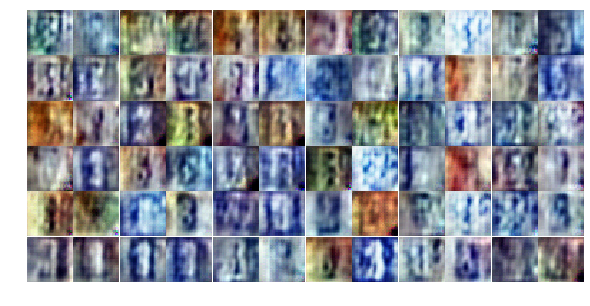

Epoch 3/100... Dloss: -173.6800 Gloss: 394.6247
Epoch 3/100... Dloss: -211.6120 Gloss: 429.4018
Epoch 3/100... Dloss: 342.0624 Gloss: -112.1941
Epoch 3/100... Dloss: -165.1865 Gloss: 368.3783
Epoch 3/100... Dloss: -253.4949 Gloss: 438.1679
Epoch 3/100... Dloss: -440.9151 Gloss: 559.0157
Epoch 3/100... Dloss: -125.9797 Gloss: 212.9164
Epoch 3/100... Dloss: -728.1857 Gloss: 854.3671
Epoch 3/100... Dloss: -532.7450 Gloss: 751.0381
Epoch 3/100... Dloss: -624.2065 Gloss: 737.9766


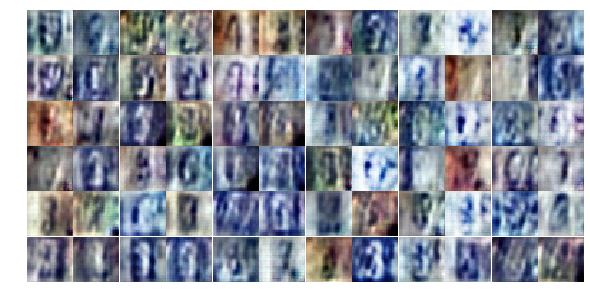

Epoch 3/100... Dloss: -372.1389 Gloss: 257.7216
Epoch 3/100... Dloss: -573.9666 Gloss: 715.8004
Epoch 3/100... Dloss: -257.9847 Gloss: 396.4533
Epoch 3/100... Dloss: -653.0626 Gloss: 814.8402
Epoch 3/100... Dloss: -344.3455 Gloss: 449.6700
Epoch 3/100... Dloss: -944.1906 Gloss: 1069.8396
Epoch 3/100... Dloss: -665.5045 Gloss: 903.1886
Epoch 3/100... Dloss: -678.8853 Gloss: 923.4181
Epoch 3/100... Dloss: -509.3215 Gloss: 390.8373
Epoch 3/100... Dloss: -187.8463 Gloss: 293.4685


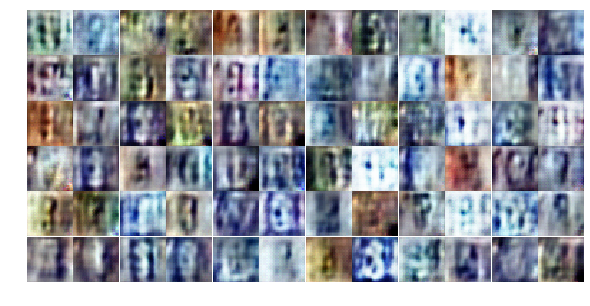

Epoch 3/100... Dloss: -61.2301 Gloss: 720.0624
Epoch 3/100... Dloss: -199.8000 Gloss: 335.1688
Epoch 3/100... Dloss: -538.8997 Gloss: 808.9662
Epoch 3/100... Dloss: -389.8142 Gloss: 507.2053
Epoch 3/100... Dloss: -597.8008 Gloss: 836.9645
Epoch 3/100... Dloss: -339.8186 Gloss: 414.6270
Epoch 3/100... Dloss: -528.0693 Gloss: 502.4492
Epoch 3/100... Dloss: -463.8154 Gloss: 636.2194
Epoch 3/100... Dloss: -136.0916 Gloss: 100.3921
Epoch 3/100... Dloss: -210.4095 Gloss: 217.9431


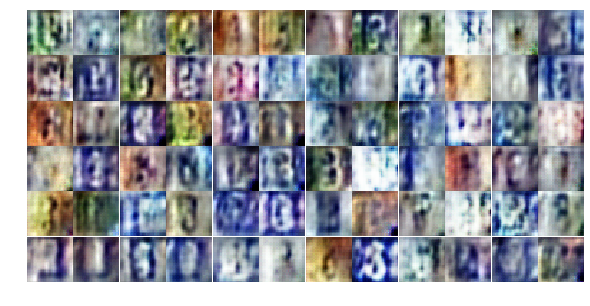

Epoch 3/100... Dloss: -475.9995 Gloss: 673.5654
(128, 100) (41, 32, 32, 3)
Epoch 4/100... Dloss: -385.0410 Gloss: 535.8418
Epoch 4/100... Dloss: -446.7597 Gloss: 656.4791
Epoch 4/100... Dloss: -725.9987 Gloss: 888.0354
Epoch 4/100... Dloss: 2.8230 Gloss: 314.7061
Epoch 4/100... Dloss: -535.3600 Gloss: 622.3929
Epoch 4/100... Dloss: -298.6801 Gloss: 577.5325
Epoch 4/100... Dloss: -857.8896 Gloss: 749.7125
Epoch 4/100... Dloss: -321.1993 Gloss: 443.8174
Epoch 4/100... Dloss: -466.2039 Gloss: 614.8818


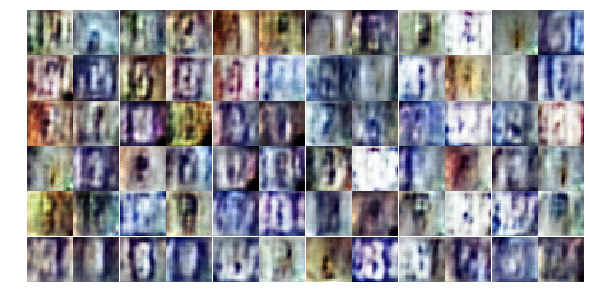

Epoch 4/100... Dloss: -552.6616 Gloss: 733.8151
Epoch 4/100... Dloss: -369.9667 Gloss: 600.2375
Epoch 4/100... Dloss: -464.7780 Gloss: 628.8013
Epoch 4/100... Dloss: -677.8039 Gloss: 794.2213
Epoch 4/100... Dloss: -492.3016 Gloss: 742.2357
Epoch 4/100... Dloss: -139.5868 Gloss: 397.3149
Epoch 4/100... Dloss: -226.0238 Gloss: 366.3153
Epoch 4/100... Dloss: -224.5932 Gloss: 340.5227
Epoch 4/100... Dloss: -866.7767 Gloss: 961.1810
Epoch 4/100... Dloss: -494.7736 Gloss: 966.0814


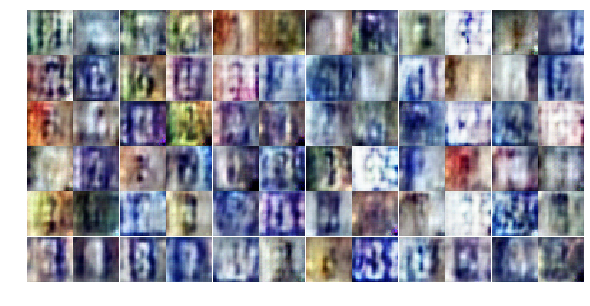

Epoch 4/100... Dloss: -737.8267 Gloss: 994.0225
Epoch 4/100... Dloss: -960.3986 Gloss: 1187.5997
Epoch 4/100... Dloss: -765.8733 Gloss: 869.3251
Epoch 4/100... Dloss: -308.1434 Gloss: 579.4971
Epoch 4/100... Dloss: -900.3855 Gloss: 1265.8069
Epoch 4/100... Dloss: -450.7034 Gloss: 885.1155
Epoch 4/100... Dloss: -476.8709 Gloss: 687.0646
Epoch 4/100... Dloss: -612.1810 Gloss: 835.3367
Epoch 4/100... Dloss: -371.0738 Gloss: 585.1931
Epoch 4/100... Dloss: -326.2463 Gloss: 714.0724


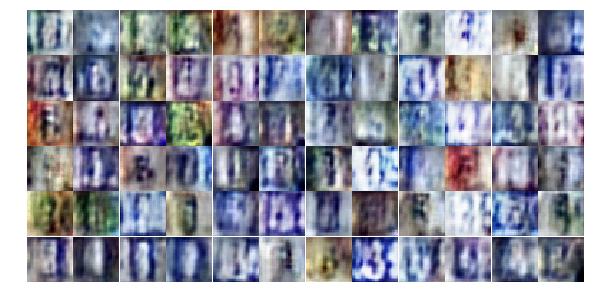

Epoch 4/100... Dloss: -132.9017 Gloss: 287.6596
Epoch 4/100... Dloss: -443.3079 Gloss: 626.1101
Epoch 4/100... Dloss: -679.0403 Gloss: 934.4288
Epoch 4/100... Dloss: -211.5596 Gloss: 396.0031
Epoch 4/100... Dloss: -365.2447 Gloss: 624.5803
Epoch 4/100... Dloss: -24.1962 Gloss: 485.4893
Epoch 4/100... Dloss: -297.1769 Gloss: 481.8105
Epoch 4/100... Dloss: -285.8329 Gloss: 552.6125
Epoch 4/100... Dloss: -333.6019 Gloss: 614.1425
Epoch 4/100... Dloss: -172.8326 Gloss: 472.0330


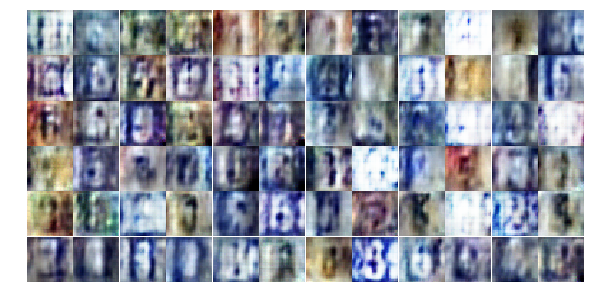

Epoch 4/100... Dloss: -653.0840 Gloss: 844.2346
Epoch 4/100... Dloss: -743.0753 Gloss: 908.1901
Epoch 4/100... Dloss: -567.4045 Gloss: 647.1664
Epoch 4/100... Dloss: -354.3379 Gloss: 548.2527
Epoch 4/100... Dloss: -132.0523 Gloss: 390.3053
Epoch 4/100... Dloss: -335.1678 Gloss: 608.6586
Epoch 4/100... Dloss: -444.7074 Gloss: 529.7594
Epoch 4/100... Dloss: -401.7040 Gloss: 646.7980
Epoch 4/100... Dloss: -309.0070 Gloss: 516.1376
Epoch 4/100... Dloss: -432.2214 Gloss: 679.4669


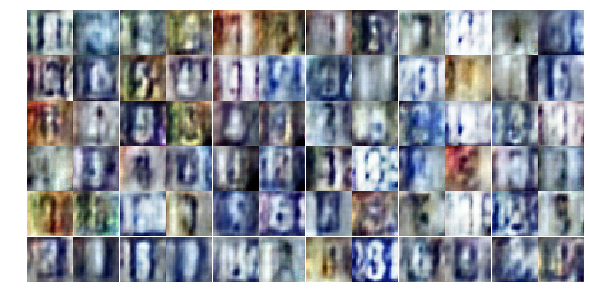

Epoch 4/100... Dloss: -769.1561 Gloss: 930.1785
Epoch 4/100... Dloss: -290.6517 Gloss: 470.8073
Epoch 4/100... Dloss: -499.2833 Gloss: 1164.7643
Epoch 4/100... Dloss: -453.9854 Gloss: 587.5005
Epoch 4/100... Dloss: -359.2642 Gloss: 647.2417
Epoch 4/100... Dloss: -605.5017 Gloss: 897.0519
Epoch 4/100... Dloss: -542.5503 Gloss: 757.2732
Epoch 4/100... Dloss: -444.7421 Gloss: 789.3037
(128, 100) (41, 32, 32, 3)
Epoch 5/100... Dloss: -604.7009 Gloss: 923.3571
Epoch 5/100... Dloss: -272.8777 Gloss: 504.3491


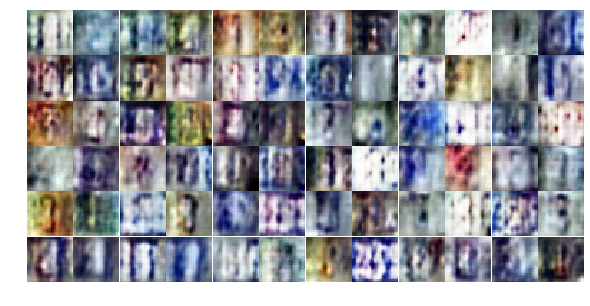

Epoch 5/100... Dloss: -343.0290 Gloss: 682.2245
Epoch 5/100... Dloss: -629.3578 Gloss: 914.4775
Epoch 5/100... Dloss: -574.6282 Gloss: 781.8278
Epoch 5/100... Dloss: -513.4330 Gloss: 696.5745
Epoch 5/100... Dloss: -259.7469 Gloss: 717.2913
Epoch 5/100... Dloss: -495.2402 Gloss: 803.5488
Epoch 5/100... Dloss: -1048.2888 Gloss: 1296.0278
Epoch 5/100... Dloss: -333.8685 Gloss: 612.6237
Epoch 5/100... Dloss: -800.9990 Gloss: 1027.5961
Epoch 5/100... Dloss: -801.4476 Gloss: 1055.8767


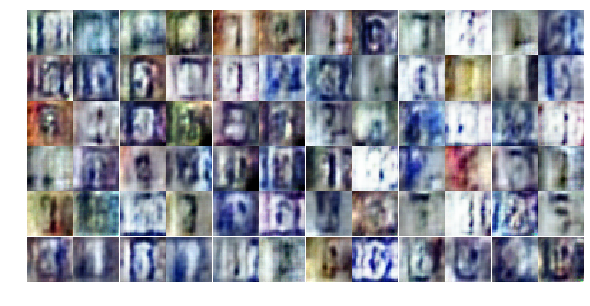

Epoch 5/100... Dloss: -682.4056 Gloss: 1025.0125
Epoch 5/100... Dloss: -324.6806 Gloss: 503.5474
Epoch 5/100... Dloss: -604.7897 Gloss: 953.8030
Epoch 5/100... Dloss: -857.7926 Gloss: 842.2563
Epoch 5/100... Dloss: -441.2889 Gloss: 913.3751
Epoch 5/100... Dloss: -664.2551 Gloss: 935.7996
Epoch 5/100... Dloss: -954.5073 Gloss: 1352.2689
Epoch 5/100... Dloss: -1004.9967 Gloss: 1486.7932
Epoch 5/100... Dloss: -694.0792 Gloss: 1299.0898
Epoch 5/100... Dloss: -727.3496 Gloss: 1161.9475


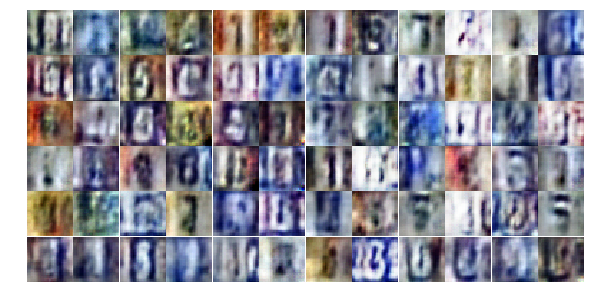

Epoch 5/100... Dloss: -786.1296 Gloss: 1208.3140
Epoch 5/100... Dloss: -1065.0844 Gloss: 1058.2466
Epoch 5/100... Dloss: -715.1292 Gloss: 962.6297
Epoch 5/100... Dloss: -708.1277 Gloss: 1084.3015
Epoch 5/100... Dloss: -525.5584 Gloss: 892.4471
Epoch 5/100... Dloss: -968.9794 Gloss: 1062.0316
Epoch 5/100... Dloss: -487.2061 Gloss: 895.1354
Epoch 5/100... Dloss: -750.8410 Gloss: 1122.6282
Epoch 5/100... Dloss: -979.0865 Gloss: 1329.1393
Epoch 5/100... Dloss: -424.0206 Gloss: 808.3267


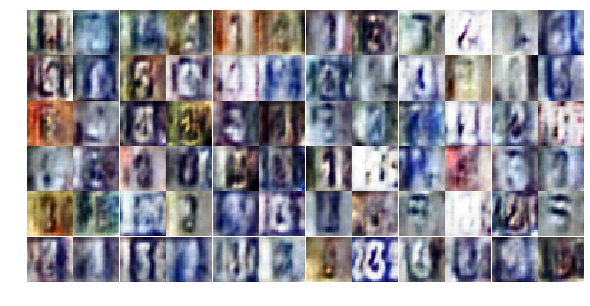

Epoch 5/100... Dloss: -794.9553 Gloss: 1214.2676
Epoch 5/100... Dloss: -485.0086 Gloss: 959.1205
Epoch 5/100... Dloss: -767.5492 Gloss: 1152.1892


In [ ]:
losses, samples = train(net=net, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

In [1]:
# Epoch 43/100... Dloss: 5.0465 Gloss: 144.2923
# Epoch 43/100... Dloss: -8.1194 Gloss: 139.4932
# Epoch 43/100... Dloss: 267.0065 Gloss: -112.0197
# Epoch 43/100... Dloss: -405.5771 Gloss: 627.8148
# Epoch 43/100... Dloss: 396.3466 Gloss: -260.8196
# Epoch 43/100... Dloss: -1380.1530 Gloss: 1556.8933

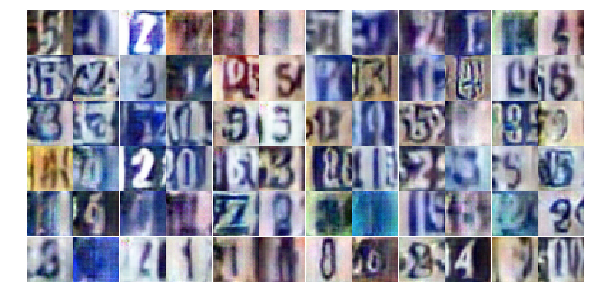

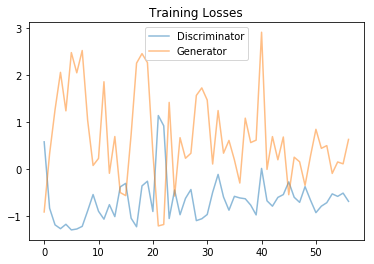

In [22]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

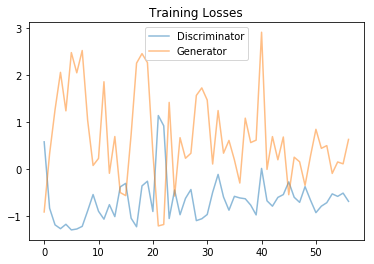

In [23]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


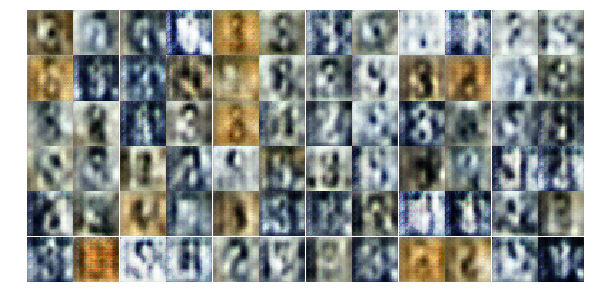

In [24]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

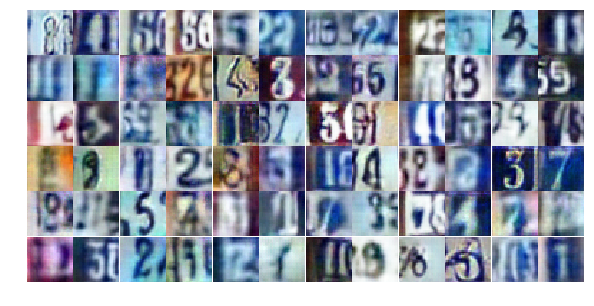

In [19]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))